In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
#################################
# check observation window does 
# not peek ahead to CVD death
#################################
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.shape)

test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.shape)

(2902784, 191)
(282688, 189)


In [4]:
print(view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))
print(test_df.columns.get_loc('PT_IMP_FATAL_CVD'))

print(view_1hot_df.iloc[:, 183].unique())
print(test_df.iloc[:, 181].unique())
cvd_death_test_ids = test_df[test_df.iloc[:, 181]==1].iloc[:, 0].unique()

183
181
[0. 1.]
[0. 1.]


In [5]:
idx = 30
#dead_ids = test_df[test_df.iloc[:, 181]==1].iloc[:, 0].unique()
#dead_inds = test_df[test_df.iloc[:, 0].isin(dead_ids)]
cvd_death_train_ids = view_1hot_df[view_1hot_df.iloc[:, 183]==1].iloc[:, 0].unique()
cvd_death_inds = view_1hot_df[view_1hot_df.iloc[:, 0].isin(cvd_death_train_ids)]
print(len(cvd_death_train_ids))
print(cvd_death_inds.shape)
print(cvd_death_inds.iloc[(idx*29):((idx+1)*29), [0,1,183]])

348
(10092, 191)
        VSIMPLE_INDEX_MASTER  QUARTER  PT_IMP_FATAL_CVD
273180  74092.0               0        0.0             
273181  74092.0               1        0.0             
273182  74092.0               2        0.0             
273183  74092.0               3        0.0             
273184  74092.0               4        0.0             
273185  74092.0               5        0.0             
273186  74092.0               6        0.0             
273187  74092.0               7        0.0             
273188  74092.0               8        0.0             
273189  74092.0               9        0.0             
273190  74092.0               10       0.0             
273191  74092.0               11       0.0             
273192  74092.0               12       0.0             
273193  74092.0               13       0.0             
273194  74092.0               14       0.0             
273195  74092.0               15       0.0             
273196  74092.0               1

In [19]:
print(view_1hot_df.columns.get_loc('DIED'))
print(test_df.columns.get_loc('DIED'))
died_train_ids = view_1hot_df[view_1hot_df.iloc[:, 17]==1].iloc[:, 0].unique()
print("DIED in train:", len(died_train_ids))
died_test_ids = test_df[test_df.iloc[:, 16]==1].iloc[:, 0].unique()
print("DIED in test:", len(died_test_ids))
print()
print("CVD deaths (train):", len(cvd_death_train_ids))
print("CVD deaths (test):", len(cvd_death_test_ids))
print()
print("Non-CVD death (train):\t", len(list(i for i in died_train_ids if\
                                           i not in set(cvd_death_train_ids))))
print("Non-CVD death (test):\t", len(list(i for i in died_test_ids if \
                                          i not in set(cvd_death_test_ids))))

17
16
DIED in train: 6634
DIED in test: 694

CVD deaths (train): 348
CVD deaths (test): 46

Non-CVD death (train):	 6286
Non-CVD death (test):	 648


In [4]:
# set up training set
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values) # or test_ if removing prediction window before scaling

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)
Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096


In [4]:
# This block removes the prediction window 
# from the test set before scaling
'''
print(train_v.shape)
print(test_.shape)
num_of_inds = test_.shape[0]//28
num_of_features = test_.shape[1]
print("Number of inds:", num_of_inds)
print("Number of features:", num_of_features)

test_v = np.empty((num_of_inds*8, test_.shape[1]))
for i in range(num_of_inds):
    ind_v = test_[(i*28):((i+1)*28), :]
    test_v[(i*8):((i+1)*8), :] = ind_v[:8, :]
print(test_v.shape)
print(test_v.shape[0]/8)
'''

'\nprint(train_v.shape)\nprint(test_.shape)\nnum_of_inds = test_.shape[0]//28\nnum_of_features = test_.shape[1]\nprint("Number of inds:", num_of_inds)\nprint("Number of features:", num_of_features)\n\ntest_v = np.empty((num_of_inds*8, test_.shape[1]))\nfor i in range(num_of_inds):\n    ind_v = test_[(i*28):((i+1)*28), :]\n    test_v[(i*8):((i+1)*8), :] = ind_v[:8, :]\nprint(test_v.shape)\nprint(test_v.shape[0]/8)\n'

In [5]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)

In [6]:
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [7]:
def setup_xy(time_series, scaled_time_series, train_or_test):
    #################################
    # construct y
    #################################
    num_of_inds = time_series.shape[0]//28
    num_of_features = time_series.shape[1]
    print("Number of individuals:", num_of_inds)

    y_ = np.empty((num_of_inds, 2))
    for i in range(num_of_inds):
        ind_v = time_series[(i*28):((i+1)*28), :]
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:163]:  # it is an acute CVD event
                event = True
            if 1.0 in ind_v[8:, 181]:
                event = True
        if event:
            y_[i, :] = np.array([0.0, 1.0])
        else:
            y_[i, :] = np.array([1.0, 0.0])
    print("Number of individuals who had a CVD event:", \
          sum(y_[:, 1]))
    print("Event ratio:", sum(y_[:, 1])/num_of_inds)
    ##################################
    # construct x
    ##################################
    x_ = np.empty((num_of_inds, 8, num_of_features))
    if train_or_test == "train":
        for i in range(num_of_inds):
            scaled_ind_v = scaled_time_series[(i*28):((i+1)*28), :]
            x_[i] = scaled_ind_v[:8, :]
    else:
        for i in range(num_of_inds):
            x_[i] = scaled_time_series[(i*8):((i+1)*8), :]
    return x_, y_

In [8]:
x_train, y_train = setup_xy(train_v, scaled_train, "train")
x_test, y_test = setup_xy(test_v, scaled_test, "train") # using "train" as prediction window not removed prior to setup()
#######################################################
# code for removing prediction window before scaling
#######################################################
#x_test, y_test = setup_xy(test_, scaled_test, "test")
#x_test = np.empty((test_v.shape[0]//8, 8, test_v.shape[1]))
#for i in range(test_v.shape[0]//8):
#    x_test[i] = scaled_test[(i*8):((i+1)*8), :]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Number of individuals: 90000
Number of individuals who had a CVD event: 11472.0
Event ratio: 0.12746666666666667
Number of individuals: 10096
Number of individuals who had a CVD event: 1357.0
Event ratio: 0.1344096671949287
(90000, 8, 182)
(90000, 2)
(10096, 8, 182)
(10096, 2)


In [9]:
######################################################
# Sample weighting -- 
# Inversely proportional contribution to cost function
# set sample weight
######################################################
unique, counts = np.unique(y_train[:, 1], return_counts=True)
print(dict(zip(unique, counts)))

s_weight = class_weight.compute_sample_weight("balanced",
                                              y_train[:, 1])
print(s_weight.shape)
print(np.unique(s_weight))
print(s_weight[:20, ])

{0.0: 78528, 1.0: 11472}
(90000,)
[0.57304401 3.92259414]
[0.57304401 0.57304401 0.57304401 0.57304401 0.57304401 0.57304401
 0.57304401 3.92259414 0.57304401 0.57304401 0.57304401 0.57304401
 0.57304401 0.57304401 0.57304401 0.57304401 0.57304401 0.57304401
 3.92259414 0.57304401]


9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 5.6720 - acc: 0.5252 - val_loss: 5.3586 - val_acc: 0.5718

Epoch 00001: val_loss improved from inf to 5.35862, saving model to EVENT_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 5.1822 - acc: 0.6046 - val_loss: 4.8915 - val_acc: 0.6306

Epoch 00002: val_loss improved from 5.35862 to 4.89146, saving model to EVENT_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 4.7324 - acc: 0.6560 - val_loss: 4.4641 - val_acc: 0.6704

Epoch 00003: val_loss improved from 4.89146 to 4.46407, saving model to EVENT_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 4.3205 - acc: 0.6842 - val_loss: 4.0738 - val_acc: 0.6927

Epoch 00004: val_loss improved from 4.46407 to 4.07378, saving model to EVENT_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 3.9442 - acc: 0.6983 - val_loss: 3.7180 - val_acc: 0.7039

Epoch 00005: val_loss

 - 1s - loss: 0.5772 - acc: 0.7275 - val_loss: 0.5746 - val_acc: 0.7280

Epoch 00043: val_loss improved from 0.57791 to 0.57463, saving model to EVENT_val_weights1.hdf5
Epoch 44/100
 - 1s - loss: 0.5739 - acc: 0.7273 - val_loss: 0.5718 - val_acc: 0.7278

Epoch 00044: val_loss improved from 0.57463 to 0.57183, saving model to EVENT_val_weights1.hdf5
Epoch 45/100
 - 1s - loss: 0.5710 - acc: 0.7269 - val_loss: 0.5695 - val_acc: 0.7281

Epoch 00045: val_loss improved from 0.57183 to 0.56951, saving model to EVENT_val_weights1.hdf5
Epoch 46/100
 - 1s - loss: 0.5686 - acc: 0.7268 - val_loss: 0.5675 - val_acc: 0.7288

Epoch 00046: val_loss improved from 0.56951 to 0.56750, saving model to EVENT_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.5665 - acc: 0.7267 - val_loss: 0.5658 - val_acc: 0.7290

Epoch 00047: val_loss improved from 0.56750 to 0.56581, saving model to EVENT_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.5646 - acc: 0.7269 - val_loss: 0.5645 - val_acc: 0.7291

Epoch 00048: val_

 - 1s - loss: 0.5464 - acc: 0.7337 - val_loss: 0.5679 - val_acc: 0.7361

Epoch 00097: val_loss did not improve from 0.55797
Epoch 98/100
 - 1s - loss: 0.5462 - acc: 0.7338 - val_loss: 0.5668 - val_acc: 0.7359

Epoch 00098: val_loss did not improve from 0.55797
Epoch 99/100
 - 1s - loss: 0.5460 - acc: 0.7341 - val_loss: 0.5686 - val_acc: 0.7353

Epoch 00099: val_loss did not improve from 0.55797
Epoch 100/100
 - 1s - loss: 0.5459 - acc: 0.7343 - val_loss: 0.5667 - val_acc: 0.7346

Epoch 00100: val_loss did not improve from 0.55797
#################################
Number of units: 16
Batch size: 16384
Fold: 0
best val loss: 0.5579652786254883
#################################


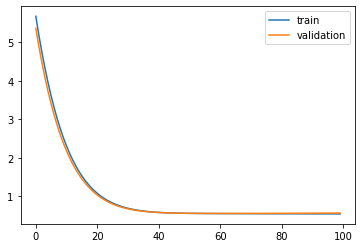

(10096, 2)


In [10]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)
#####################################
#LSTM
units = 16
batch_s = 16384
L2_1 = 0.05441600579314996
#####################################
#L2_2 = 2.092561938722815e-05
#lr = 0.04113387739738984
#decay = 1.566949434233884e-06
#####################################
# Simple RNN 
#units = 8 #2
#batch_s = 8192 #256
#L2_1 = 0.10788586002261571
######################################

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train2_x, train1_x, axis=0) 
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lstm = np.append(train2_y, train1_y, axis=0)
    
    start_time_inner = time.time()
    #config = tf.ConfigProto(log_device_placement = True)
    #config.gpu_options.visible_device_list='1'
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = Sequential()
        model.add(CuDNNLSTM(units,
                            kernel_regularizer=regularizers.l2(L2_1),
                            #return_sequences=True, 
                            input_shape=(8, 182))) #20 , 27
        #model.add(CuDNNLSTM(units, 
        #                   kernel_regularizer=regularizers.l2(L2_2)))
                            #return_sequences=True))
        model.add(Dense(2, activation='softmax'))
        #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
        #sgdm = optimizers.SGD(lr=lr, momentum=0.9, decay=decay) 
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', 
                      #weighted_metrics=['loss'],
                      metrics=['accuracy'])
        val_weight = "EVENT_val_weights" + str(f+1) + ".hdf5"
        val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
        history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                            epochs=100, validation_split=0.1, 
                            callbacks=[val_checkpointer], 
                            verbose=2, 
                            shuffle=False,
                            #class_weight = {0:0.1, 1:0.9}
                            sample_weight=class_weight.\
                                          compute_sample_weight("balanced",
                                                               train_y_lstm[:, 1])
                           ) 
        print("#################################")
        print("Number of units:", units)
        print("Batch size:", batch_s)
        #print("Learning rate:", lr)
        #print("Decay:", decay)
        print("Fold:", f)
        print("best val loss:", min(history.history['val_loss']))
        print("#################################")
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
print(yhat_test.shape)

In [11]:
print(yhat_test.shape)
yhat_test_df = pd.DataFrame(yhat_test)
#y_test_df = pd.DataFrame(y_test)
yhat_test_df.columns = ['NO_EVENT', 'EVENT']
#y_test_df.columns = ['NO_EVENT', 'EVENT']
feather.write_dataframe(yhat_test_df, "/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_yhat_testI.feather")
#feather.write_dataframe(y_test_df, "/home/whsu014/data/EVENT_y.feather")

(10096, 2)


## Models comparison

In [5]:
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_class_weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_sample_weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_2Layers_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_yhat.feather")
lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_yhat_testI.feather")# repeat above 
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_Sample_Weight_yhat_test.feather")# remove x from test before scaling test

#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SGDM_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SetupXThenScale_yhat.feather")#no sample weight
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SetupXThenScale_Sample_Weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LSTM_L201_SetupXThenScale_Sample_Weight_HParams_yhat.feather")

#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_yhat.feather")
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_Sample_Weight_yhat.feather")
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_Sample_Weight_yhat.feather")
#rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RNN_L201_Sample_Weight_yhat_test.feather")# remove x from test before scaling test

#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_Sample_Weight_yhat.feather")
#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_SetupXThenScale_Sample_Weight_yhat.feather")
#mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_MLP_SetupXThenScale_Sample_Weight_HParams_yhat.feather")

rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_yhat.feather")
#####rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_normalized_yhat.feather")
#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_normalized_Class_Weight_yhat.feather")
#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_yhat_test.feather")


rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_aggregated_yhat.feather")
#rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_aggregated_normalized_yhat.feather")
#rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_aggregated_normalized_Class_Weight_yhat.feather")

rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_last_quarter_yhat.feather") #this is normalised
#rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_RC_last_quarter_normalized_Class_Weight_yhat.feather")

#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_yhat_10000iter.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_Class_Weight_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_normalized_Class_weight_yhat_10000iter.feather")

#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_yhat.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_yhat.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_yhat_1000iter.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_Class_Weight_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_Class_weight_yhat_test.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_aggregated_normalized_Class_weight_yhat_1000iter.feather")

#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_yhat.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_yhat_10000iter.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_Class_Weight_yhat.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_LR_last_quarter_normalized_Class_weight_yhat_10000iter.feather")

cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_aggregated_yhat_10096inds.feather")
#cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_aggregated_normalized_yhat.feather")

#cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_last_quarter_yhat_10096inds.feather")
#cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_last_quarter_normalized_yhat.feather")

cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_last_quarter_yhat_test.feather")


#####################################
# Multi_PDC_EVENT
#####################################
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_EVENT_LSTM_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_EVENT_LSTM_Sample_Weight_yhat.feather")


#####################################
# balanced data
# linear model experiment
#####################################
'''
rc_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_RC_yhat.feather")
rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_RC_aggregated_yhat.feather")
rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_RC_last_quarter_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_LR_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_LR_aggregated_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_LR_last_quarter_yhat.feather")
cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_balanced_aggregated_yhat.feather")
cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_EVENT_balanced_last_quarter_yhat.feather")
y_df = feather.read_dataframe("/home/whsu014/data/EVENT_balanced_y_test.feather")
y_df = pd.concat([y_df, y_df], axis=1)
print(y_df.shape)
'''
##########################################################

y_df = feather.read_dataframe("/home/whsu014/data/EVENT_y.feather")
#y_df.columns = ['NO EVENT', 'EVENT']
#feather.write_dataframe("/home/whsu014/data/EVENT_y.feather")
#y_mlp_df = feather.read_dataframe("/home/whsu014/data/PDC_y_MLP.feather")

lstm_yhat = lstm_yhat_df.values
rnn_yhat = rnn_yhat_df.values
mlp_yhat = mlp_yhat_df.values

rc_yhat = rc_yhat_df.values
rc_a_yhat = rc_a_yhat_df.values
rc_l_yhat = rc_l_yhat_df.values
lr_yhat = lr_yhat_df.values
lr_a_yhat = lr_a_yhat_df.values
lr_l_yhat = lr_l_yhat_df.values
cox_a_yhat = cox_a_yhat_df.values
cox_l_yhat = cox_l_yhat_df.values

y = y_df.values

LSTM:			ROC AUC = 0.788
RNN:			ROC AUC = 0.786
MLP:			ROC AUC = 0.783
RC:			ROC AUC = 0.785
RC (aggregated):	ROC AUC = 0.787
RC (last quarter):	ROC AUC = 0.780
LR:			ROC AUC = 0.784
LR (aggregated):	ROC AUC = 0.788
LR (last quarter):	ROC AUC = 0.781
Cox (aggregated):	ROC AUC = 0.783
Cox (last quarter):	ROC AUC = 0.778


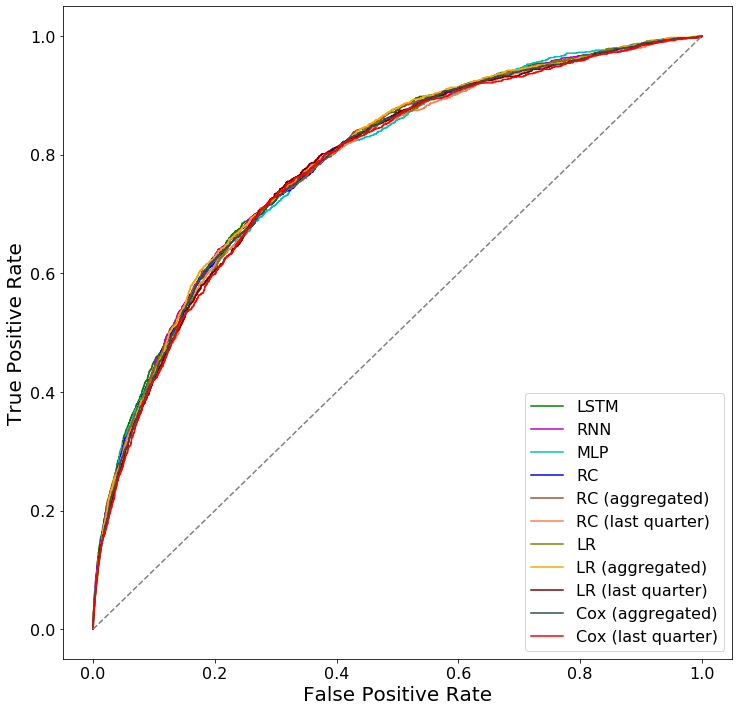

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fs = 20

lstm_auc = roc_auc_score(y[:, 1], 
                         lstm_yhat[:, 1])
rnn_auc = roc_auc_score(y[:, 1],
                         rnn_yhat[:, 1])
mlp_auc = roc_auc_score(y[:, 1],
                         mlp_yhat[:, 1])

rc_auc = roc_auc_score(y[:, 1], 
                          rc_yhat[:, 0])
rc_a_auc = roc_auc_score(y[:, 1], 
                          rc_a_yhat[:, 0])
rc_l_auc = roc_auc_score(y[:, 1],
                         rc_l_yhat[:, 0])
lr_auc = roc_auc_score(y[:, 1],
                         lr_yhat[:, 0])
lr_a_auc = roc_auc_score(y[:, 1],
                         lr_a_yhat[:, 0])
lr_l_auc = roc_auc_score(y[:, 1],
                         lr_l_yhat[:, 0])
cox_a_auc = roc_auc_score(y[:, 1],
                         cox_a_yhat[:, 0])
cox_l_auc = roc_auc_score(y[:, 1],
                         cox_l_yhat[:, 0])

print('LSTM:\t\t\tROC AUC = %.3f' % (lstm_auc))
print('RNN:\t\t\tROC AUC = %.3f' %(rnn_auc))
print('MLP:\t\t\tROC AUC = %.3f' %(mlp_auc))
print('RC:\t\t\tROC AUC = %.3f' %(rc_auc))
print('RC (aggregated):\tROC AUC = %.3f' %(rc_a_auc))
print('RC (last quarter):\tROC AUC = %.3f' %(rc_l_auc))
print('LR:\t\t\tROC AUC = %.3f' %(lr_auc))
print('LR (aggregated):\tROC AUC = %.3f' %(lr_a_auc))
print('LR (last quarter):\tROC AUC = %.3f' %(lr_l_auc))
print('Cox (aggregated):\tROC AUC = %.3f' %(cox_a_auc))
print('Cox (last quarter):\tROC AUC = %.3f' %(cox_l_auc))

lstm_fp, lstm_tp, _ = roc_curve(y[:, 1], 
                                lstm_yhat[:, 1])
rnn_fp, rnn_tp, _ = roc_curve(y[:, 1], 
                              rnn_yhat[:, 1])
mlp_fp, mlp_tp, _ = roc_curve(y[:, 1], 
                              mlp_yhat[:, 1])

rc_fp, rc_tp, _ = roc_curve(y[:, 1], 
                            rc_yhat[:, 0])
rc_a_fp, rc_a_tp, _ = roc_curve(y[:, 1], 
                            rc_a_yhat[:, 0])
rc_l_fp, rc_l_tp, _ = roc_curve(y[:, 1], 
                            rc_l_yhat[:, 0])
lr_fp, lr_tp, _ = roc_curve(y[:, 1],
                            lr_yhat[:, 0])
lr_a_fp, lr_a_tp, _ = roc_curve(y[:, 1],
                            lr_a_yhat[:, 0])
lr_l_fp, lr_l_tp, _ = roc_curve(y[:, 1], 
                            lr_l_yhat[:, 0])
cox_a_fp, cox_a_tp, _ = roc_curve(y[:, 1],
                                 cox_a_yhat[:, 0])
cox_l_fp, cox_l_tp, _ = roc_curve(y[:, 1],
                                 cox_l_yhat[:, 0])

pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(12,12))

pyplot.plot(lstm_fp, lstm_tp, color='g', 
            linestyle='-', label='LSTM')
pyplot.plot(rnn_fp, rnn_tp, color='m', 
            linestyle='-', label='RNN')    
pyplot.plot(mlp_fp, mlp_tp, color='c', 
             linestyle='-', label='MLP')
pyplot.plot(rc_fp, rc_tp, color='b', 
             linestyle='-', label='RC')
pyplot.plot(rc_a_fp, rc_a_tp, color='sienna', 
             linestyle='-', label='RC (aggregated)')
pyplot.plot(rc_l_fp, rc_l_tp, color='coral', 
             linestyle='-', label='RC (last quarter)')

pyplot.plot(lr_fp, lr_tp, color='olive', 
             linestyle='-', label='LR')
pyplot.plot(lr_a_fp, lr_a_tp, color='orange', 
             linestyle='-', label='LR (aggregated)')
pyplot.plot(lr_l_fp, lr_l_tp, color='maroon', 
             linestyle='-', label='LR (last quarter)')
pyplot.plot(cox_a_fp, cox_a_tp, color='darkslategray', 
             linestyle='-', label='Cox (aggregated)')
pyplot.plot(cox_l_fp, cox_l_tp, color='red', 
             linestyle='-', label='Cox (last quarter)')#'lightseagreen'


pyplot.plot([0, 1], [0, 1], color='grey', linestyle='--')
#pyplot.title('ROC curves CVD event prediction', fontsize=fs*1.1)
pyplot.xlabel('False Positive Rate', fontsize=fs)
pyplot.ylabel('True Positive Rate', fontsize=fs)
pyplot.legend(fontsize=fs*0.8, loc='lower right')
filename = "/home/whsu014/plots/EVENT_ROC_Curves_no_title.png"
#pyplot.savefig(filename)
pyplot.show()

LSTM			Average precision-recall score: 0.421
RNN			Average precision-recall score: 0.414
MLP			Average precision-recall score: 0.409
RC			Average precision-recall score: 0.413
RC (aggregated)		Average precision-recall score: 0.414
RC (last quarter)	Average precision-recall score: 0.404
LR 			Average precision-recall score: 0.401
LR (aggregated)		Average precision-recall score: 0.409
LR (last quarter)	Average precision-recall score: 0.397
Cox (aggregated)	Average precision-recall score: 0.403
Cox (last quarter)	Average precision-recall score: 0.391

LSTM			Precision-recall AUC : 0.421
RNN			Precision-recall AUC : 0.414
MLP			Precision-recall AUC : 0.408
RC			Precision-recall AUC : 0.412
RC (aggregated):	Precision-recall AUC : 0.414
RC (last quarter):	Precision-recall AUC : 0.403
LR 			Precision-recall AUC : 0.400
LR (aggregated):	Precision-recall AUC : 0.409
LR (last quarter):	Precision-recall AUC : 0.396
Cox (aggregated):	Precision-recall AUC : 0.402
Cox (last quarter):	Precision-recal

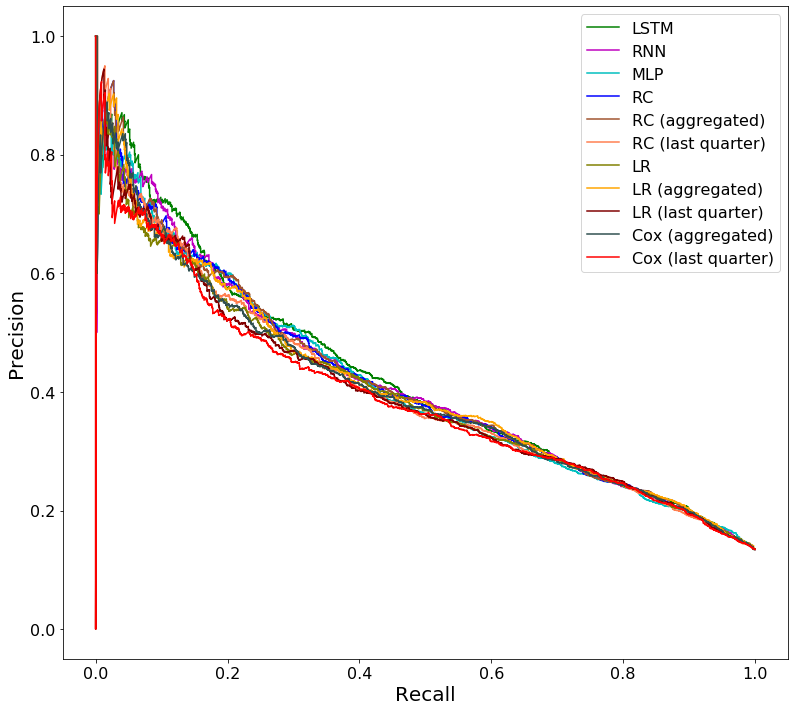

In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

fs = 20

lstm_p, lstm_r, _ = precision_recall_curve(y[:, 1], 
                                lstm_yhat[:, 1])
rnn_p, rnn_r, _ = precision_recall_curve(y[:, 1], 
                              rnn_yhat[:, 1])
mlp_p, mlp_r, _ = precision_recall_curve(y[:, 1], 
                              mlp_yhat[:, 1])

rc_p, rc_r, _ = precision_recall_curve(y[:, 1], 
                            rc_yhat[:, 0])
rc_a_p, rc_a_r, _ = precision_recall_curve(y[:, 1], 
                            rc_a_yhat[:, 0])
rc_l_p, rc_l_r, _ = precision_recall_curve(y[:, 1], 
                            rc_l_yhat[:, 0])
lr_p, lr_r, _ = precision_recall_curve(y[:, 1], 
                            lr_yhat[:, 0])
lr_a_p, lr_a_r, _ = precision_recall_curve(y[:, 1], 
                            lr_a_yhat[:, 0])
lr_l_p, lr_l_r, _ = precision_recall_curve(y[:, 1], 
                            lr_l_yhat[:, 0])
cox_a_p, cox_a_r, _ = precision_recall_curve(y[:, 1], 
                            cox_a_yhat[:, 0])
cox_l_p, cox_l_r, _ = precision_recall_curve(y[:, 1], 
                            cox_l_yhat[:, 0])

average_lstm_p = average_precision_score(y[:, 1], 
                                         lstm_yhat[:, 1])
average_rnn_p = average_precision_score(y[:, 1], 
                                         rnn_yhat[:, 1])
average_mlp_p = average_precision_score(y[:, 1], 
                                         mlp_yhat[:, 1])

average_rc_p = average_precision_score(y[:, 1], 
                                         rc_yhat[:, 0])
average_rc_a_p = average_precision_score(y[:, 1], 
                                         rc_a_yhat[:, 0])
average_rc_l_p = average_precision_score(y[:, 1], 
                                         rc_l_yhat[:, 0])
average_lr_p = average_precision_score(y[:, 1], 
                                         lr_yhat[:, 0])
average_lr_a_p = average_precision_score(y[:, 1], 
                                         lr_a_yhat[:, 0])
average_lr_l_p = average_precision_score(y[:, 1], 
                                         lr_l_yhat[:, 0])
average_cox_a_p = average_precision_score(y[:, 1], 
                                         cox_a_yhat[:, 0])
average_cox_l_p = average_precision_score(y[:, 1], 
                                         cox_l_yhat[:, 0])

print('LSTM\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_lstm_p))
print('RNN\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_rnn_p))
print('MLP\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_mlp_p))

print('RC\t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_rc_p))
print('RC (aggregated)\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_rc_a_p))
print('RC (last quarter)\tAverage precision-recall score: {0:0.3f}'.format(
      average_rc_l_p))
print('LR \t\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_lr_p))
print('LR (aggregated)\t\tAverage precision-recall score: {0:0.3f}'.format(
      average_lr_a_p))
print('LR (last quarter)\tAverage precision-recall score: {0:0.3f}'.format(
      average_lr_l_p))
print('Cox (aggregated)\tAverage precision-recall score: {0:0.3f}'.format(
      average_cox_a_p))
print('Cox (last quarter)\tAverage precision-recall score: {0:0.3f}'.format(
      average_cox_l_p))
print()

lstm_pr_auc = auc(lstm_r, lstm_p)
rnn_pr_auc = auc(rnn_r, rnn_p)
mlp_pr_auc = auc(mlp_r, mlp_p)

rc_pr_auc = auc(rc_r, rc_p)
rc_a_pr_auc = auc(rc_a_r, rc_a_p) #added a
rc_l_pr_auc = auc(rc_l_r, rc_l_p)
lr_pr_auc = auc(lr_r, lr_p)
lr_a_pr_auc = auc(lr_a_r, lr_a_p)
lr_l_pr_auc = auc(lr_l_r, lr_l_p)
cox_a_pr_auc = auc(cox_a_r, cox_a_p)
cox_l_pr_auc = auc(cox_l_r, cox_l_p)

print('LSTM\t\t\tPrecision-recall AUC : %.3f' % (lstm_pr_auc))
print('RNN\t\t\tPrecision-recall AUC : %.3f' %(rnn_pr_auc))
print('MLP\t\t\tPrecision-recall AUC : %.3f' %(mlp_pr_auc))

print('RC\t\t\tPrecision-recall AUC : %.3f' %(rc_pr_auc))
print('RC (aggregated):\tPrecision-recall AUC : %.3f' %(rc_a_pr_auc))
print('RC (last quarter):\tPrecision-recall AUC : %.3f' %(rc_l_pr_auc))
print('LR \t\t\tPrecision-recall AUC : %.3f' %(lr_pr_auc))
print('LR (aggregated):\tPrecision-recall AUC : %.3f' %(lr_a_pr_auc))
print('LR (last quarter):\tPrecision-recall AUC : %.3f' %(lr_l_pr_auc))
print('Cox (aggregated):\tPrecision-recall AUC : %.3f' %(cox_a_pr_auc))
print('Cox (last quarter):\tPrecision-recall AUC : %.3f' %(cox_l_pr_auc))

pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(13,12))

pyplot.plot(lstm_r, lstm_p, color='g', 
            linestyle='-', label='LSTM')
pyplot.plot(rnn_r, rnn_p, color='m', 
            linestyle='-', label='RNN')
pyplot.plot(mlp_r, mlp_p, color='c', 
             linestyle='-', label='MLP')

pyplot.plot(rc_r, rc_p, color='b', 
             linestyle='-', label='RC')
pyplot.plot(rc_a_r, rc_a_p, color='sienna', 
             linestyle='-', label='RC (aggregated)')
pyplot.plot(rc_l_r, rc_l_p, color='coral', 
             linestyle='-', label='RC (last quarter)')
pyplot.plot(lr_r, lr_p, color='olive', 
             linestyle='-', label='LR')
pyplot.plot(lr_a_r, lr_a_p, color='orange', 
             linestyle='-', label='LR (aggregated)')
pyplot.plot(lr_l_r, lr_l_p, color='maroon', 
             linestyle='-', label='LR (last quarter)')
pyplot.plot(cox_a_r, cox_a_p, color='darkslategray', 
             linestyle='-', label='Cox (aggregated)')
pyplot.plot(cox_l_r, cox_l_p, color='red', 
             linestyle='-', label='Cox (last quarter)')#'lightseagreen'

#pyplot.plot([0, 1], color='grey', linestyle='--')
#pyplot.title('Precision-recall curves CVD event prediction', fontsize=fs*1.1)
pyplot.xlabel('Recall', fontsize=fs)
pyplot.ylabel('Precision', fontsize=fs)
pyplot.legend(fontsize=fs*0.8)
filename = "/home/whsu014/plots/EVENT_PR_Curves_no_title.png"
#pyplot.savefig(filename)
pyplot.show()

## subplot

/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


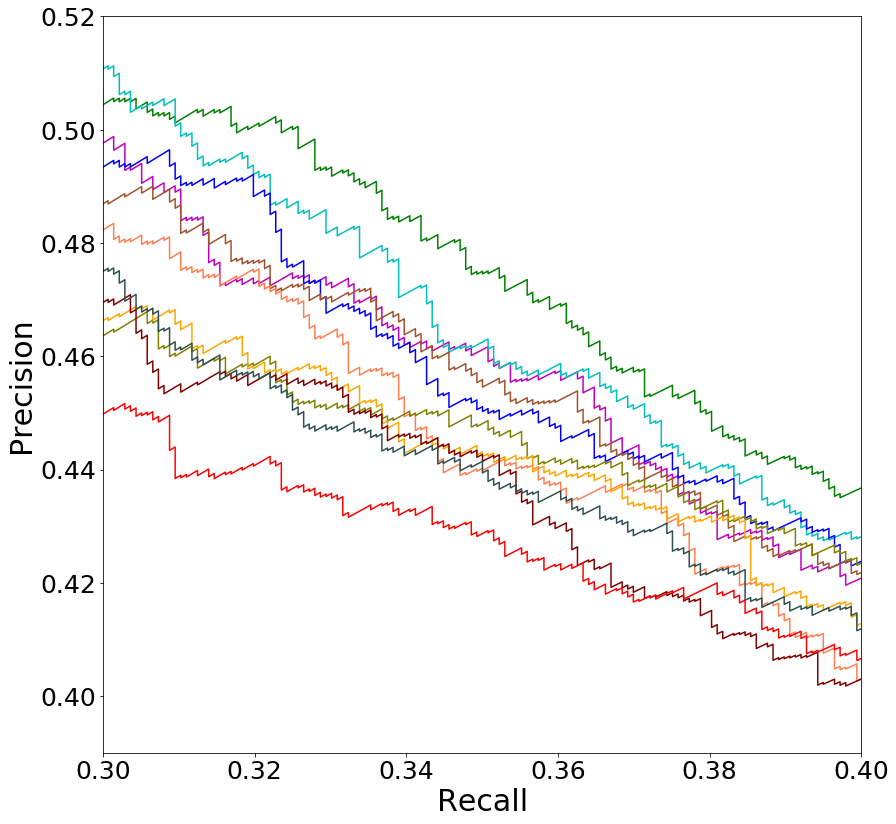

In [6]:
fs = 25
pyplot.rcParams.update({'font.size':25})
pyplot.figure(figsize=(13,12))
pyplot.margins(0)

ax1 = pyplot.subplot(111)

#ax1.set_xlim(left = 0.7, right= 0.8)
#ax1.set_ylim(bottom = 0.24, top = 0.29)

#ax1.set_xlim(left = 0.8, right= 0.9)
#ax1.set_ylim(bottom = 0.19, top = 0.25)

#ax1.set_xlim(left = 0.9, right= 1)
#ax1.set_ylim(bottom = 0.13, top = 0.21)

#ax1.set_xlim(left = 0.1, right= 0.2)
#ax1.set_ylim(bottom = 0.5, top = 0.74)

#ax1.set_xlim(left = 0.2, right= 0.3)
#ax1.set_ylim(bottom = 0.44, top = 0.61)

ax1.set_xlim(left = 0.3, right= 0.4)
ax1.set_ylim(bottom = 0.39, top = 0.52)

ax1.plot(lstm_r, lstm_p, color='g', 
            linestyle='-', label='LSTM')

ax1.plot(rnn_r, rnn_p, color='m', 
            linestyle='-', label='RNN')
ax1.plot(mlp_r, mlp_p, color='c', 
             linestyle='-', label='MLP')

ax1.plot(rc_r, rc_p, color='b', 
             linestyle='-', label='RC')
ax1.plot(rc_a_r, rc_a_p, color='sienna', 
             linestyle='-', label='RC (aggregated)')
ax1.plot(rc_l_r, rc_l_p, color='coral', 
             linestyle='-', label='RC (last quarter)')
ax1.plot(lr_r, lr_p, color='olive', 
             linestyle='-', label='LR')
ax1.plot(lr_a_r, lr_a_p, color='orange', 
             linestyle='-', label='LR (aggregated)')
ax1.plot(lr_l_r, lr_l_p, color='maroon', 
             linestyle='-', label='LR (last quarter)')
ax1.plot(cox_a_r, cox_a_p, color='darkslategray', 
             linestyle='-', label='Cox (aggregated)')
ax1.plot(cox_l_r, cox_l_p, color='red', 
             linestyle='-', label='Cox (last quarter)') #'lightseagreen'
             
#pyplot.plot([0, 1], color='grey', linestyle='--')
#yplot.title('Precision-recall curves CVD event prediction \n detail (recall in the range [0.9, 1.0])', fontsize=fs*1.1)
pyplot.xlabel('Recall', fontsize=fs*1.2)
pyplot.ylabel('Precision', fontsize=fs*1.2)
#pyplot.legend(fontsize=fs*1.5)
pyplot.tight_layout()
filename = "/home/whsu014/plots/EVENT_PR_Curves_detail_03_no_title_no_legend.png"
#pyplot.savefig(filename)
pyplot.show()

In [4]:
print(len(_))
print(len(lstm_p))
print(len(lstm_r))

10095
10095
10095


## Model Calibration

In [15]:
print(lstm_yhat.shape)
print(rc_yhat.shape)
print(lr_yhat.shape)
print(cox_a_yhat.shape)

print("LSTM min:\t", np.round(min(lstm_yhat[:, 1]), decimals=5))
print("LSTM max:\t", np.round(max(lstm_yhat[:, 1]), decimals=5))

print("RNN min:\t", np.round(min(rnn_yhat[:, 1]), decimals=5))
print("RNN max:\t", np.round(max(rnn_yhat[:, 1]), decimals=5))

print("MLP min:\t", np.round(min(mlp_yhat[:, 1]), decimals=5))
print("MLP max:\t", np.round(max(mlp_yhat[:, 1]), decimals=5))

print("RC min:\t\t", np.round(min(rc_yhat[:, 0]), decimals=5))
print("RC max:\t\t", np.round(max(rc_yhat[:, 0]), decimals=5))
print("LR min:\t\t", np.round(min(lr_yhat[:, 0]), decimals=5))
print("LR max:\t\t", np.round(max(lr_yhat[:, 0]), decimals=5))
print("Cox min:\t", np.round(min(cox_a_yhat[:, 0]), decimals=5))
print("Cox max:\t", np.round(max(cox_l_yhat[:, 0]), decimals=5))

(10096, 2)
(10096, 1)
(10096, 1)
(10096, 1)
LSTM min:	 0.00636
LSTM max:	 0.97283
RNN min:	 0.04689
RNN max:	 0.9757
MLP min:	 2e-05
MLP max:	 1.0
RC min:		 -1.24828
RC max:		 1.16478
LR min:		 -4.8969
LR max:		 4.5465
Cox min:	 0.0
Cox max:	 0.99607


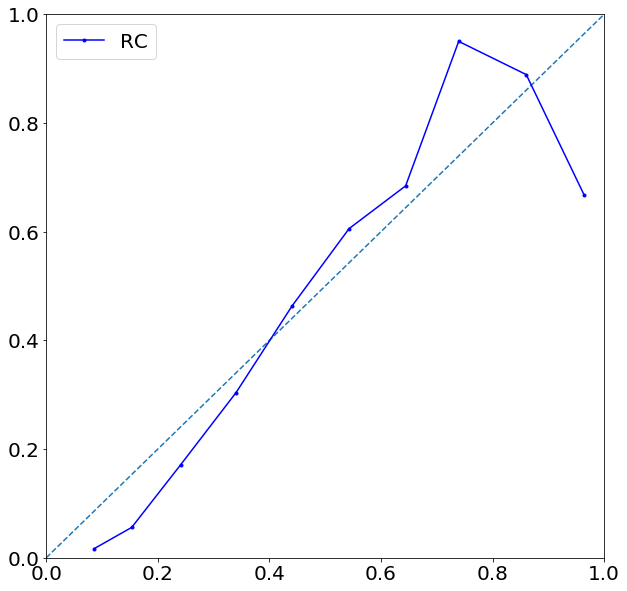

In [37]:
fs = 25
pyplot.rcParams.update({'font.size':20})
pyplot.figure(figsize=(10, 10))
pyplot.margins(0)

prob_true, prob_pred = calibration_curve(y[:, 1], 
                                         #lstm_yhat[:, 1], 
                                         rc_yhat[:],
                                         normalize=True,
                                         n_bins = 10)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(prob_pred, prob_true, marker='.', color='b', label='RC')
pyplot.legend()
pyplot.show()

In [49]:
##########################################
# Implement own calibration function
##########################################
def calibration(y_yhat, bins):
    step = 1.0/bins
    mean_pred_prob = []
    n_list = []
    p_list = []
    proportion_positive = []
    for i in range(bins):
        temp_v = y_yhat[y_yhat[:, 1] > i*step]
        temp_v = temp_v[temp_v[:, 1] <= (i+1)*step]
        if len(temp_v) != 0 :
            mean_pred_prob.append(np.mean(temp_v[:, 1]))
            print("Mean pred prob:", np.mean(temp_v[:, 1]))
            positive_samples_in_bin = temp_v[temp_v[:, 0] == 1]
            n_list.append(temp_v.shape[0])
            p_list.append(positive_samples_in_bin.shape[0])
            print("Number in bin:", temp_v.shape[0])
            print("Positive sample in bin:", positive_samples_in_bin.shape[0])
            proportion_positive.append(positive_samples_in_bin.shape[0]/temp_v.shape[0])
            print("Proportion of positive samples:",
              positive_samples_in_bin.shape[0]/temp_v.shape[0])
    return mean_pred_prob, proportion_positive, n_list, p_list

In [50]:
print(rc_yhat.shape)
print(min(rc_yhat))
print(max(rc_yhat))
#####################################
# normalise decision function
#####################################
yhat = rc_yhat

yhat = (yhat[:, 0] - min(yhat[:, 0]))/(max(yhat[:, 0] - min(yhat[:, 0])))

print(yhat.shape)
print(min(yhat))
print(max(yhat))

(10096, 1)
[0.]
[1.]
(10096,)
0.0
1.0


In [51]:
print(y.shape)
print(yhat.shape)
# NN models
#y_yhat = np.append(np.array([y[:, 1]]).T, 
#                            np.array([lstm_yhat[:, 0]]).T,
#                            axis=1)
# Linear models
y_yhat = np.append(np.array([y[:, 1]]).T, 
                            np.array([yhat]).T,
                            axis=1)
# cox models
#y_yhat = np.append(np.array([y[:, 1]]).T,
#                            np.array([cox_a_yhat[:, 0]]).T,
#                            axis=1)
print(y_yhat.shape)

m_pred_prob, prop_pos, n_list, p_list = calibration(y_yhat, 10)
print(sum(n_list))
print(sum(p_list))

(10096, 2)
(10096,)
(10096, 2)
Mean pred prob: 0.08595901833120437
Number in bin: 418
Positive sample in bin: 7
Proportion of positive samples: 0.01674641148325359
Mean pred prob: 0.15323656189600376
Number in bin: 5633
Positive sample in bin: 315
Proportion of positive samples: 0.05592046866678502
Mean pred prob: 0.24098452488786962
Number in bin: 2523
Positive sample in bin: 432
Proportion of positive samples: 0.17122473246135553
Mean pred prob: 0.3403618944038716
Number in bin: 934
Positive sample in bin: 284
Proportion of positive samples: 0.30406852248394006
Mean pred prob: 0.44071944669733976
Number in bin: 356
Positive sample in bin: 165
Proportion of positive samples: 0.46348314606741575
Mean pred prob: 0.5428814940004316
Number in bin: 142
Positive sample in bin: 86
Proportion of positive samples: 0.6056338028169014
Mean pred prob: 0.644149082833266
Number in bin: 57
Positive sample in bin: 39
Proportion of positive samples: 0.6842105263157895
Mean pred prob: 0.739219615917722

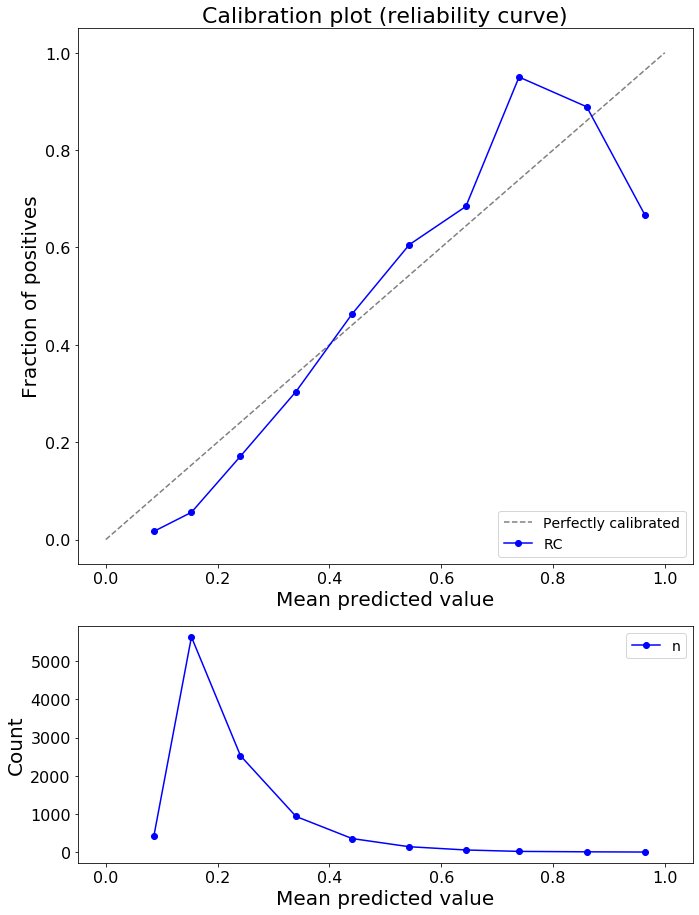

In [52]:
'''
---data---
lstm_yhat    color='g'
rnn_yhat     color='m'
mlp_yhat     color='c'
rc_yhat      color='b'
rc_a_yhat    color='sienna'
rc_l_yhat    color='coral'
lr_yhat      color='olive'
lr_a_yhat    color='orange'
lr_l_yhat    color='maroon'
cox_a_yhat   color='darkslategray'
cox_l_yhat   color='lightseagreen'
y 
'''
pyplot.rcParams.update({'font.size':16})
fs = 20
print()
pyplot.figure(figsize=(10, 13))
ax1 = pyplot.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = pyplot.subplot2grid((3, 1), (2, 0))
color = 'b' 
ax1.set_title('Calibration plot (reliability curve)', fontsize=fs*1.1)
ax1.set_xlabel('Mean predicted value', fontsize=fs)
ax1.set_ylabel('Fraction of positives', fontsize=fs)
ax1.set_xlim([-0.05, 1.05])
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
ax1.plot(m_pred_prob, prop_pos, marker='o',color=color, label='RC')
ax1.legend(loc='lower right',  fontsize=fs*0.7)
#ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=fs*0.8)
color1 = 'b' 
ax2.set_xlabel('Mean predicted value', fontsize=fs)
ax2.set_ylabel('Count', fontsize=fs)
ax2.set_xlim([-0.05, 1.05])
ax2.plot(m_pred_prob, n_list, marker='o', color=color1, label="n")
ax2.legend(loc='upper right', fontsize=fs*0.7)
#ax2.plot(m_pred_prob, p_list, marker='o', color=color2, label="Positive samples")
#ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=fs*0.8)
filename = "/home/whsu014/plots/Calibration_balanced_Cox_aggregated.png"
#pyplot.savefig(filename)
pyplot.tight_layout()
pyplot.show()

## Subgroup analysis

In [6]:
print(test_df.shape)
print(test_v.shape)
print(test_df.shape[0]/28)
print(lstm_yhat_df.shape)
print(y_df.shape)

(282688, 189)
(282688, 182)
10096.0
(10096, 2)
(10096, 2)


In [7]:
list(test_df.columns)
print(test_v.shape[0]/28)
num_of_inds = test_v.shape[0]//28
print(num_of_inds)

covariates_list = []
for i in range(num_of_inds):
    ind_v = test_v[(i*28):((i+1)*28), :9]
    covariates_list.append(ind_v[7, :])
covariates_v = np.array(covariates_list)
print(covariates_v.shape)
covariates_df = pd.DataFrame(covariates_v)
covariates_df.columns = list(test_df.columns)[:9]
covariates_df.head()

10096.0
10096
(10096, 9)


,VSIMPLE_INDEX_MASTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5
0,75768.0,52.25,0.0,3.0,1.0,0.0,0.0,0.0,0.0
1,786.0,61.25,1.0,2.0,0.0,1.0,0.0,0.0,0.0
2,46831.0,51.75,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,11007.0,68.25,1.0,5.0,1.0,0.0,0.0,0.0,0.0
4,41081.0,52.00,0.0,5.0,0.0,1.0,0.0,0.0,0.0


In [11]:
####################################
# Need to normalise RC and LR
# decision function so it can be 
# interpreted as prediction probability
# see: https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py
####################################

rc_yhat_df.iloc[:, 0] = (rc_yhat_df.iloc[:, 0] - min(rc_yhat_df.iloc[:, 0]))/\
                        (max(rc_yhat_df.iloc[:, 0]) - min(rc_yhat_df.iloc[:, 0]))
rc_a_yhat_df.iloc[:, 0] = (rc_a_yhat_df.iloc[:, 0] - min(rc_a_yhat_df.iloc[:, 0]))/\
                          (max(rc_a_yhat_df.iloc[:, 0]) - min(rc_a_yhat_df.iloc[:, 0]))
rc_l_yhat_df.iloc[:, 0] = (rc_l_yhat_df.iloc[:, 0] - min(rc_l_yhat_df.iloc[:, 0]))/\
                          (max(rc_l_yhat_df.iloc[:, 0]) - min(rc_l_yhat_df.iloc[:, 0]))
lr_yhat_df.iloc[:, 0] = (lr_yhat_df.iloc[:, 0] - min(lr_yhat_df.iloc[:, 0]))/\
                        (max(lr_yhat_df.iloc[:, 0]) - min(lr_yhat_df.iloc[:, 0]))
lr_a_yhat_df.iloc[:, 0] = (lr_a_yhat_df.iloc[:, 0] - min(lr_a_yhat_df.iloc[:, 0]))/\
                          (max(lr_a_yhat_df.iloc[:, 0]) - min(lr_a_yhat_df.iloc[:, 0]))
lr_l_yhat_df.iloc[:, 0] = (lr_l_yhat_df.iloc[:, 0] - min(lr_l_yhat_df.iloc[:, 0]))/\
                          (max(lr_l_yhat_df.iloc[:, 0]) - min(lr_l_yhat_df.iloc[:, 0]))

col_names = list(covariates_df.columns)
analysis_df = pd.concat([covariates_df, 
                             y_df.iloc[:, 1], 
                             lstm_yhat_df.iloc[:, 1],
                             rnn_yhat_df.iloc[:, 1],
                             mlp_yhat_df.iloc[:, 1],
                             rc_yhat_df.iloc[:, 0],
                             rc_a_yhat_df.iloc[:, 0],
                             rc_l_yhat_df.iloc[:, 0],
                             lr_yhat_df.iloc[:, 0],
                             lr_a_yhat_df.iloc[:, 0],
                             lr_l_yhat_df.iloc[:, 0],
                             cox_a_yhat_df.iloc[:, 0],
                             cox_l_yhat_df.iloc[:, 0]],
                             axis=1)
print(analysis_df.shape)
col_names.extend(['Y', 'LSTM', 'RNN', 'MLP', 'RC',
                  'RC_A', 'RC_L', 'LR', 'LR_A', 'LR_L',
                  'COX_A', 'COX_L'])
analysis_df.columns = col_names
#analysis_df.head(20)

(10096, 21)


In [30]:
analysis_df.describe()

,VSIMPLE_INDEX_MASTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5,Y,LSTM,RNN,MLP,RC,RC_A,RC_L,LR,LR_A,LR_L,COX_A,COX_L
count,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000,10096.000000
mean,49572.049822,61.991457,0.434529,3.061609,0.574089,0.101327,0.146989,0.088946,0.088649,0.134410,0.403666,0.405542,0.400470,0.210097,0.177078,0.218517,0.278128,0.258550,0.315851,0.128372,0.128736
std,28838.217611,11.388801,0.495720,1.473681,0.494505,0.301777,0.354112,0.284680,0.284250,0.341109,0.235858,0.237013,0.219213,0.102819,0.088062,0.111302,0.110038,0.095931,0.115184,0.127813,0.130737
min,0.000000,21.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006359,0.046894,0.000023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24404.250000,54.250000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200603,0.195144,0.212197,0.143614,0.121078,0.147111,0.200603,0.191959,0.235764,0.054238,0.053514
50%,49806.500000,62.250000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358261,0.369375,0.361724,0.181925,0.153384,0.186626,0.258722,0.242361,0.294424,0.084704,0.081651
75%,74314.500000,70.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.584216,0.581033,0.565593,0.246157,0.207408,0.257584,0.337210,0.308297,0.377763,0.150758,0.149191
max,100093.000000,95.500000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972829,0.975701,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996069


In [14]:
############################################ 
## Compute Brier Score for each classifier
############################################
# only use positive class sample
# sex == 1 (Female)
print(analysis_df.shape)
sub_analysis_df = copy.deepcopy(analysis_df)#analysis_df[analysis_df['Y']==1]
sub_analysis_df = sub_analysis_df[sub_analysis_df['ETHN_1']==1]
print(sub_analysis_df.shape)


b_lstm = sum((sub_analysis_df['LSTM'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_rnn = sum((sub_analysis_df['RNN'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_mlp = sum((sub_analysis_df['MLP'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_rc = sum((sub_analysis_df['RC'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_rc_a = sum((sub_analysis_df['RC_A'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_rc_l = sum((sub_analysis_df['RC_L'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_lr = sum((sub_analysis_df['LR'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_lr_a = sum((sub_analysis_df['LR_A'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_lr_l = sum((sub_analysis_df['LR_L'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_cox_a = sum((sub_analysis_df['COX_A'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]
b_cox_l = sum((sub_analysis_df['COX_L'] - sub_analysis_df['Y'])**2)/sub_analysis_df.shape[0]

print("LSTM Brier score:\t", np.round(b_lstm, decimals = 5))
print("RNN Brier score:\t", np.round(b_rnn, decimals = 5))
print("MLP Brier score:\t", np.round(b_mlp, decimals = 5))
print("RC Brier score:\t\t", np.round(b_rc, decimals = 5))
print("RC_A Brier score:\t", np.round(b_rc_a, decimals = 5))
print("RC_L Brier score:\t", np.round(b_rc_l, decimals = 5))
print("LR Brier score:\t\t", np.round(b_lr, decimals = 5))
print("LR_A Brier score:\t", np.round(b_lr_a, decimals = 5))
print("LR_L Brier score:\t", np.round(b_lr_l, decimals = 5))
print("COX_A Brier score:\t", np.round(b_cox_a, decimals = 5))
print("COX_L Brier score:\t", np.round(b_cox_l, decimals = 5))
###################
# verify LSTM
###################
sum_sq_err = 0
for i in range(sub_analysis_df.shape[0]):
    err = sub_analysis_df.iloc[i, 10] - sub_analysis_df.iloc[i, 9]
    sum_sq_err += (err)**2
print(sum_sq_err/sub_analysis_df.shape[0])

(10096, 21)
(5796, 21)
LSTM Brier score:	 0.197
RNN Brier score:	 0.19961
MLP Brier score:	 0.19347
RC Brier score:		 0.10997
RC_A Brier score:	 0.10707
RC_L Brier score:	 0.11147
LR Brier score:		 0.12668
LR_A Brier score:	 0.12129
LR_L Brier score:	 0.13955
COX_A Brier score:	 0.10452
COX_L Brier score:	 0.10514
0.19699920860167838


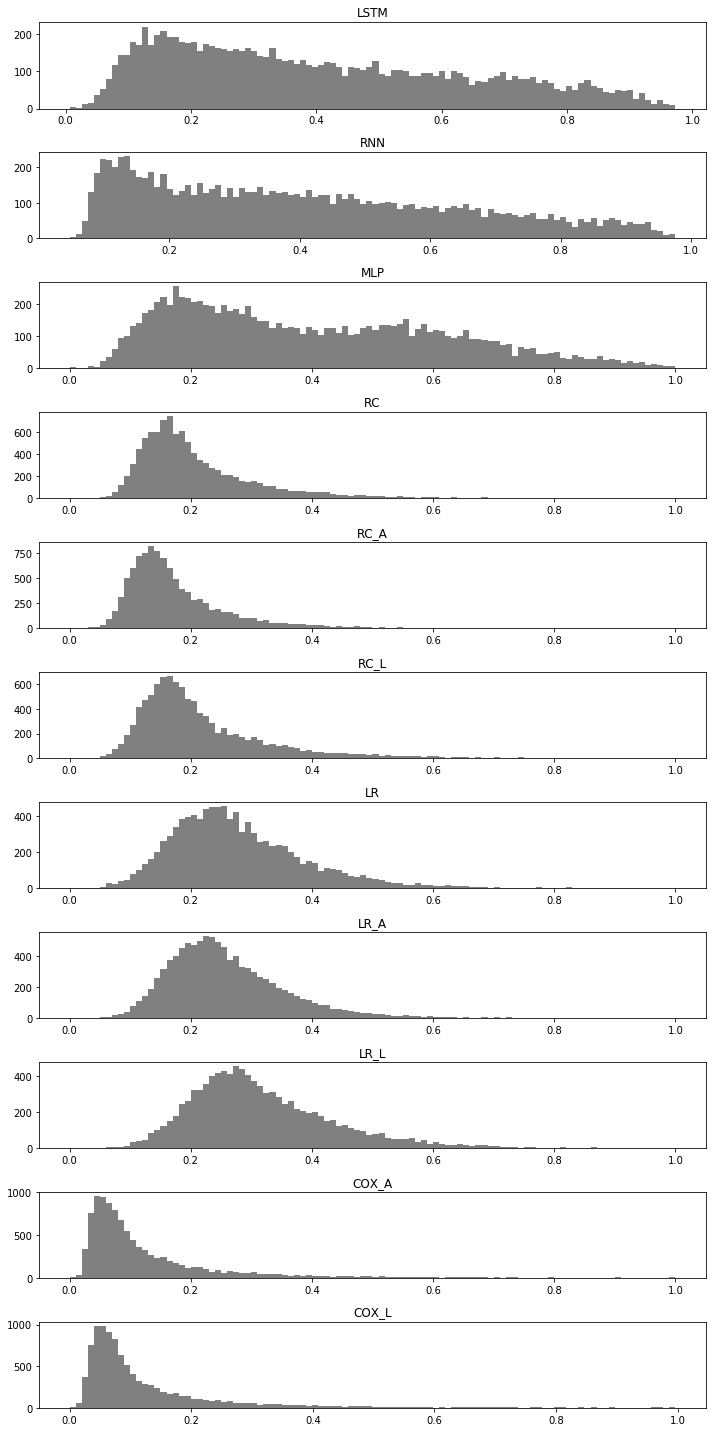

In [16]:
fig, axs = pyplot.subplots(11, 1, figsize=(10, 20))
pyplot.subplots_adjust(hspace=0.5)

model_names = ['LSTM', 'RNN', 'MLP', 'RC', 'RC_A', 
               'RC_L', 'LR', 'LR_A', 'LR_L', 'COX_A',
               'COX_L']

for i in range(11):
    axs[i].hist(sub_analysis_df[model_names[i]], bins=100,
                color='gray')
    axs[i].title.set_text(model_names[i])

filename = "/home/whsu014/plots/CVD_Event_probability_estimates_distribution.png"
pyplot.tight_layout()
pyplot.savefig(filename)
pyplot.show()

In [8]:
#############################
# Get subgroup statistics
# ROC AUC, Average Precision
#############################
'''
sub_df = sub_analysis_df[sub_analysis_df['ETHN_5'] == 1]
print(sub_df.shape)
roc_score = roc_auc_score(sub_df.iloc[:, 9], 
                          sub_df.iloc[:, 10])
print("ROC AUC:\t\t %.3f" %(roc_score))
average_precision = average_precision_score(sub_df.iloc[:, 9], 
                                            sub_df.iloc[:, 10])

print("Average precision:\t %.3f" %(average_precision))
_p, _r, _ = precision_recall_curve(sub_df.iloc[:, 9], 
                                   sub_df.iloc[:, 10])

pr_auc = auc(_r, _p)
print("Precision-recall AUC:\t\t\t %.3f" %(pr_auc))
'''

(895, 11)
ROC AUC:		 0.828
Average precision:	 0.450
Precision-recall AUC:	 0.447


In [11]:
cvd_death_df = view_1hot_df[view_1hot_df.PT_IMP_FATAL_CVD == 1]
cvd_deaths_ids = cvd_death_df.VSIMPLE_INDEX_MASTER.unique()
print(len(cvd_deaths_ids))

348


In [14]:
cvd_death_df = test_df[test_df.PT_IMP_FATAL_CVD == 1]
cvd_deaths_ids = cvd_death_df.VSIMPLE_INDEX_MASTER.unique()
print(len(cvd_deaths_ids))

46


## Wilcoxon sign-rank test 
## Splitting test set into 10 folds

(10096, 2)
(10096, 2)
(10096, 1)
1009
[[0.4073716  0.39788302]
 [0.44051399 0.44696548]
 [0.44051889 0.43174376]
 [0.41003726 0.39817155]
 [0.44747851 0.41724449]
 [0.49864657 0.48168868]
 [0.38365546 0.37452287]
 [0.40200344 0.40983452]
 [0.33039167 0.33108645]
 [0.48926416 0.48519258]]


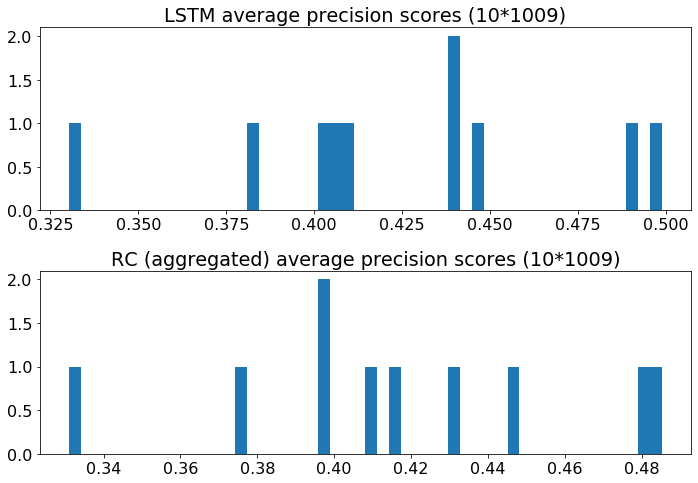

Sum of the ranks:  8.0
p_value:  0.04685328478814715


In [43]:
from sklearn.metrics import average_precision_score
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind

print(y.shape)
print(lstm_yhat.shape)
print(rc_yhat.shape)

n_per_fold = y.shape[0]//10
print(n_per_fold) # 504 use 10080 samples

ap_scores = np.empty((10, 2))

for i in range(10):
    # NN models
    ap_scores[i, 0] = average_precision_score(y[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 1], 
                                             lstm_yhat[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 1])
    #ap_scores[i, 1] = average_precision_score(y[(i*n_per_fold):
    #                                         ((i+1)*n_per_fold), 1], 
    #                                         mlp_yhat[(i*n_per_fold):
    #                                         ((i+1)*n_per_fold), 1])
    # linear Models
    #ap_scores[i, 0] = average_precision_score(y[(i*n_per_fold):
    #                                         ((i+1)*n_per_fold), 1],
    #                                          lr_a_yhat[(i*n_per_fold):
    #                                         ((i+1)*n_per_fold), 0])
    ap_scores[i, 1] = average_precision_score(y[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 1],
                                              rc_a_yhat[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 0])
print(ap_scores)
stats, p = wilcoxon(ap_scores[:, 0], ap_scores[:, 1])
#stats, p = ttest_ind(ap_scores[:, 0], ap_scores[:, 1])

fig, axs = pyplot.subplots(2,1, figsize=(10, 7))
axs[0].hist(ap_scores[:, 0], bins=50)
axs[0].set_title("LSTM average precision scores (10*1009)")
axs[1].hist(ap_scores[:, 1], bins=50)
axs[1].set_title("RC (aggregated) average precision scores (10*1009)")
fig.tight_layout()
pyplot.show()

print("Sum of the ranks: ", stats)
print("p_value: ", p)

## Bootstrapping 100* 10,000 samples

In [20]:
print(y.shape)
print(lstm_yhat.shape)
print(rc_a_yhat.shape)
print(type(rc_a_yhat))
n_samples = y.shape[0]
y_lstm_rc_a = np.concatenate((y[:, 1].reshape(n_samples, 1), 
                              lstm_yhat[:, 1].reshape(n_samples, 1), 
                              rc_a_yhat[:, 0].reshape(n_samples, 1)), axis=1)
print(y_lstm_rc_a.shape)
print(y_lstm_rc_a[-10:, :])

(10096, 2)
(10096, 2)
(10096, 2)
<class 'numpy.ndarray'>
(10096, 3)
[[0.         0.33420411 0.36841369]
 [0.         0.41060561 0.40615559]
 [0.         0.60467303 0.55648148]
 [0.         0.40226731 0.42403659]
 [0.         0.75158954 0.75715363]
 [0.         0.51939839 0.484467  ]
 [0.         0.14014858 0.16531205]
 [0.         0.23426782 0.22871034]
 [0.         0.45555562 0.53081745]
 [0.         0.24461222 0.31278586]]


In [9]:
from numpy.random import seed
seed(1)

n_samples = y_lstm_rc_a.shape[0]
print("Number of samples:", n_samples)
n_samples_per_fold = 10000
bstrap_v = np.zeros(((100 * n_samples_per_fold), 3))

print(np.unique(bstrap_v[:, 0]))

idx_list = []

for i in range(100):
    for j in range(n_samples_per_fold):
        idx = np.random.randint(0, n_samples)
        idx_list.append(idx)
        bstrap_v[((i*n_samples_per_fold)+j), :] = y_lstm_rc_a[idx, :]    
print(np.unique(bstrap_v[:, 0]))

Number of samples: 10096
[0.]
[0. 1.]


[[0.         0.36196843 0.39670229]
 [0.         0.17899714 0.17642473]
 [0.         0.72591269 0.7303865 ]
 [0.         0.40263087 0.32800823]
 [0.         0.31511268 0.35957325]
 [0.         0.3813279  0.3973119 ]
 [1.         0.53519893 0.58331108]
 [0.         0.41159213 0.41332799]
 [0.         0.26626647 0.23422474]
 [1.         0.60632724 0.62611514]]


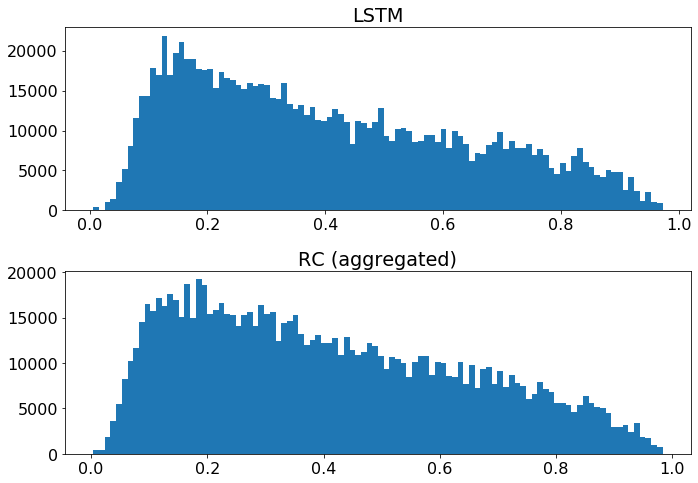

In [22]:
print(bstrap_v[-10:, :])
pyplot.rcParams.update({'font.size':16})
#pyplot.figure(figsize=(10, 13))

fig, axs = pyplot.subplots(2,1, figsize=(10, 7))
axs[0].hist(bstrap_v[:, 1], bins=100)
axs[0].set_title("LSTM")
axs[1].hist(bstrap_v[:, 2], bins=100)
axs[1].set_title("RC (aggregated)")
fig.tight_layout()
pyplot.show()

## Wilcoxon sign-rank test 
## using bootstrap samples

Number per fold: 10000
[[0.42880488 0.42647394]
 [0.44054149 0.4309023 ]
 [0.4241067  0.42094338]
 [0.39292594 0.38748263]
 [0.43438823 0.43274645]
 [0.39622828 0.38677007]
 [0.43325966 0.42123686]
 [0.42231479 0.41397414]
 [0.41590277 0.41877248]
 [0.40292754 0.39442086]
 [0.40757442 0.40027983]
 [0.42983737 0.42925339]
 [0.4339836  0.4267615 ]
 [0.44106246 0.43366032]
 [0.41437786 0.40983618]
 [0.41498077 0.41040325]
 [0.44624791 0.42844005]
 [0.43766235 0.43400211]
 [0.40512448 0.40361637]
 [0.43570742 0.42704272]
 [0.45034062 0.44229092]
 [0.43628277 0.43139722]
 [0.41407757 0.41117179]
 [0.40894169 0.4177849 ]
 [0.43834059 0.43533458]
 [0.41808174 0.41181727]
 [0.43456215 0.42493018]
 [0.45142591 0.44507347]
 [0.41601883 0.40831169]
 [0.41525229 0.41362183]
 [0.42220962 0.41251307]
 [0.44706264 0.44045236]
 [0.43514344 0.42874247]
 [0.41804692 0.41363417]
 [0.43365433 0.42932031]
 [0.43486338 0.42799012]
 [0.41026737 0.41620973]
 [0.40211366 0.39913003]
 [0.43234024 0.43218805]
 [

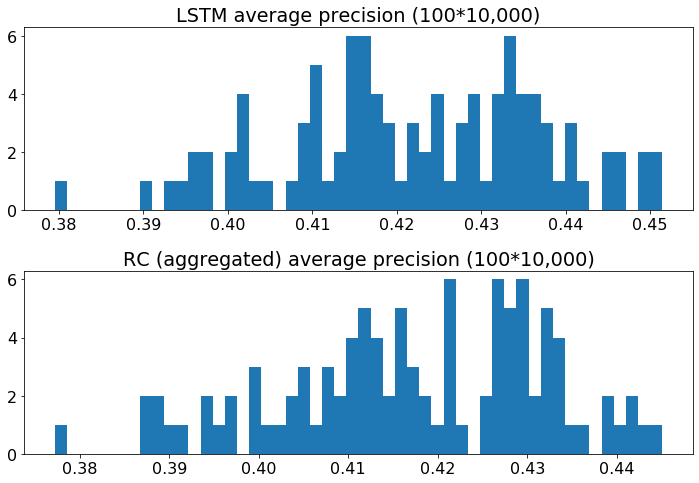

Sum of the ranks:  295.0
p_value:  1.7542968918093306e-14


In [23]:
from sklearn.metrics import average_precision_score
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind

n_per_fold = bstrap_v.shape[0]//100
print("Number per fold:", n_per_fold) # 504 use 10080 samples

ap_scores = np.empty((100, 2))

for i in range(100):
    # NN models
    ap_scores[i, 0] = average_precision_score(bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 0], 
                                             bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 1])
    ap_scores[i, 1] = average_precision_score(bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 0],
                                              bstrap_v[(i*n_per_fold):
                                             ((i+1)*n_per_fold), 2])
print(ap_scores)
fig, axs = pyplot.subplots(2,1, figsize=(10, 7))
axs[0].hist(ap_scores[:, 0], bins=50)
axs[0].set_title("LSTM average precision (100*10,000)")
axs[1].hist(ap_scores[:, 1], bins=50)
axs[1].set_title("RC (aggregated) average precision (100*10,000)")
fig.tight_layout()
pyplot.show()

stats, p = wilcoxon(ap_scores[:, 0], ap_scores[:, 1])
#stats, p = ttest_ind(ap_scores[:, 0], ap_scores[:, 1])
print("Sum of the ranks: ", stats)
print("p_value: ", p)

In [27]:
print("LSTM min average precision: %.7f " %np.min(ap_scores[:, 0]))
print("LSTM max average precision: %.6f \n" %np.max(ap_scores[:, 0]))
print("RC min average precision: %.7f " %np.min(ap_scores[:, 1]))
print("RC max average precision: %.7f \n" %np.max(ap_scores[:, 1]))

LSTM min average precision: 0.3794955 
LSTM max average precision: 0.451426 

RC min average precision: 0.3790064 
RC max average precision: 0.4443392 



In [24]:
ap_scores_df = pd.DataFrame(ap_scores)
ap_scores_df.columns = ['LSTM_SINGLE_EVENT', 'LSTM_MULTI_EVENT']
feather.write_dataframe(ap_scores_df, "/home/whsu014/data/LSTM_single_multi_ap_scores.feather")

## Check data symmetry (mean and median close together)
## Wilcoxon sign-rank test assumption

In [28]:
print(np.mean(ap_scores[:, 0]))
print(np.median(ap_scores[:, 0]))

print(np.mean(ap_scores[:, 1]))
print(np.median(ap_scores[:, 1]))

0.4220175994574992
0.42243120777524734
0.4150718702049742
0.4148238905899073


## Prepare for autorank test
## bootstrap 100 * 10,000

In [3]:
print(y.shape)
print(lstm_yhat.shape)
print(rc_a_yhat.shape)
print(type(rc_a_yhat))
n_samples = y.shape[0]
y_yhats_v = np.concatenate((y[:, 1].reshape(n_samples, 1), 
                          lstm_yhat[:, 1].reshape(n_samples, 1), 
                          rnn_yhat[:, 1].reshape(n_samples, 1),
                          mlp_yhat[:, 1].reshape(n_samples, 1),
                          rc_yhat[:, 0].reshape(n_samples, 1),
                          rc_a_yhat[:, 0].reshape(n_samples, 1),
                          rc_l_yhat[:, 0].reshape(n_samples, 1),
                          lr_yhat[:, 0].reshape(n_samples, 1),
                          lr_a_yhat[:, 0].reshape(n_samples, 1),
                          lr_l_yhat[:, 0].reshape(n_samples, 1), 
                          cox_a_yhat[:, 0].reshape(n_samples, 1),
                          cox_l_yhat[:, 0].reshape(n_samples, 1)), axis=1)
print(y_yhats_v.shape)
print(np.round(y_yhats_v[-10:, :], decimals=3))

(10096, 2)
(10096, 2)
(10096, 1)
<class 'numpy.ndarray'>
(10096, 12)
[[ 0.     0.334  0.326  0.357 -0.85  -0.869 -0.847 -2.694 -0.764 -2.564
   0.07   0.073]
 [ 0.     0.411  0.296  0.473 -0.792 -0.739 -0.785 -2.441 -0.37  -2.318
   0.093  0.088]
 [ 0.     0.605  0.609  0.569 -0.658 -0.664 -0.645 -1.593  0.344 -1.508
   0.17   0.169]
 [ 0.     0.402  0.42   0.52  -0.747 -0.748 -0.739 -2.042 -0.186 -2.031
   0.111  0.112]
 [ 0.     0.752  0.746  0.727 -0.421 -0.408 -0.471 -0.583  1.496 -0.884
   0.302  0.293]
 [ 0.     0.519  0.511  0.573 -0.71  -0.705 -0.765 -1.805  0.116 -2.146
   0.135  0.103]
 [ 0.     0.14   0.139  0.179 -0.956 -0.952 -0.948 -3.167 -1.311 -3.129
   0.047  0.047]
 [ 0.     0.234  0.247  0.347 -0.873 -0.878 -0.868 -2.642 -0.918 -2.718
   0.061  0.064]
 [ 0.     0.456  0.519  0.382 -0.764 -0.763 -0.778 -2.119 -0.21  -2.257
   0.098  0.091]
 [ 0.     0.245  0.269  0.211 -0.846 -0.785 -0.821 -2.729 -0.666 -2.586
   0.076  0.073]]


In [10]:
from numpy.random import seed
seed(1)

n_samples = y_yhats_v.shape[0]
print("Number of samples:", n_samples)
n_samples_per_fold = 10000
bstrap_v = np.zeros(((100 * n_samples_per_fold), 12))

print(np.unique(bstrap_v[:, 0]))

idx_list = []

for i in range(100):
    for j in range(n_samples_per_fold):
        idx = np.random.randint(0, n_samples)
        idx_list.append(idx)
        bstrap_v[((i*n_samples_per_fold)+j), :] = y_yhats_v[idx, :]    
print(np.unique(bstrap_v[:, 0]))

Number of samples: 10096
[0.]
[0. 1.]


In [24]:
where_v = np.where(bstrap_v[:, 1:]==0)
print(len(list(where_v[0])))
print(len(list(where_v[1])))

292
292


7829
9
(1000000, 12)
[ 1.00000000e+00  7.75543042e-03  5.21706454e-02  1.00000000e+00
 -7.44699320e-01 -7.55463744e-01 -7.76162360e-01 -1.74486775e+00
  2.64344560e-02 -1.98939862e+00  0.00000000e+00  2.08737992e-07]


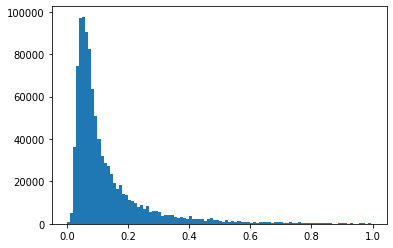

In [27]:
print(where_v[0][1])
print(where_v[1][1])
print(bstrap_v.shape)
print(bstrap_v[(7829),])
pyplot.hist(bstrap_v[:, 11], bins=100)
pyplot.show()

Number per fold: 10000
[[0.429 0.423 0.412 0.415 0.42  0.405 0.402 0.415 0.402 0.411 0.397]
 [0.441 0.436 0.42  0.43  0.431 0.416 0.419 0.427 0.41  0.42  0.402]
 [0.424 0.416 0.414 0.417 0.417 0.407 0.408 0.416 0.402 0.409 0.396]
 [0.393 0.381 0.386 0.386 0.388 0.369 0.377 0.383 0.363 0.376 0.358]
 [0.434 0.432 0.431 0.434 0.432 0.427 0.419 0.428 0.418 0.421 0.41 ]
 [0.396 0.394 0.392 0.393 0.397 0.389 0.374 0.392 0.381 0.387 0.377]
 [0.433 0.422 0.411 0.417 0.415 0.407 0.405 0.409 0.399 0.401 0.39 ]
 [0.422 0.403 0.406 0.413 0.411 0.403 0.395 0.401 0.391 0.394 0.382]
 [0.416 0.409 0.407 0.413 0.415 0.406 0.401 0.41  0.397 0.404 0.386]
 [0.403 0.398 0.39  0.397 0.399 0.388 0.388 0.396 0.382 0.39  0.377]
 [0.408 0.401 0.397 0.402 0.401 0.393 0.389 0.394 0.385 0.389 0.379]
 [0.43  0.431 0.427 0.427 0.425 0.421 0.418 0.426 0.414 0.418 0.407]
 [0.434 0.42  0.414 0.426 0.431 0.41  0.408 0.42  0.399 0.416 0.395]
 [0.441 0.435 0.436 0.433 0.435 0.428 0.42  0.427 0.419 0.421 0.411]
 [0.414 0.4

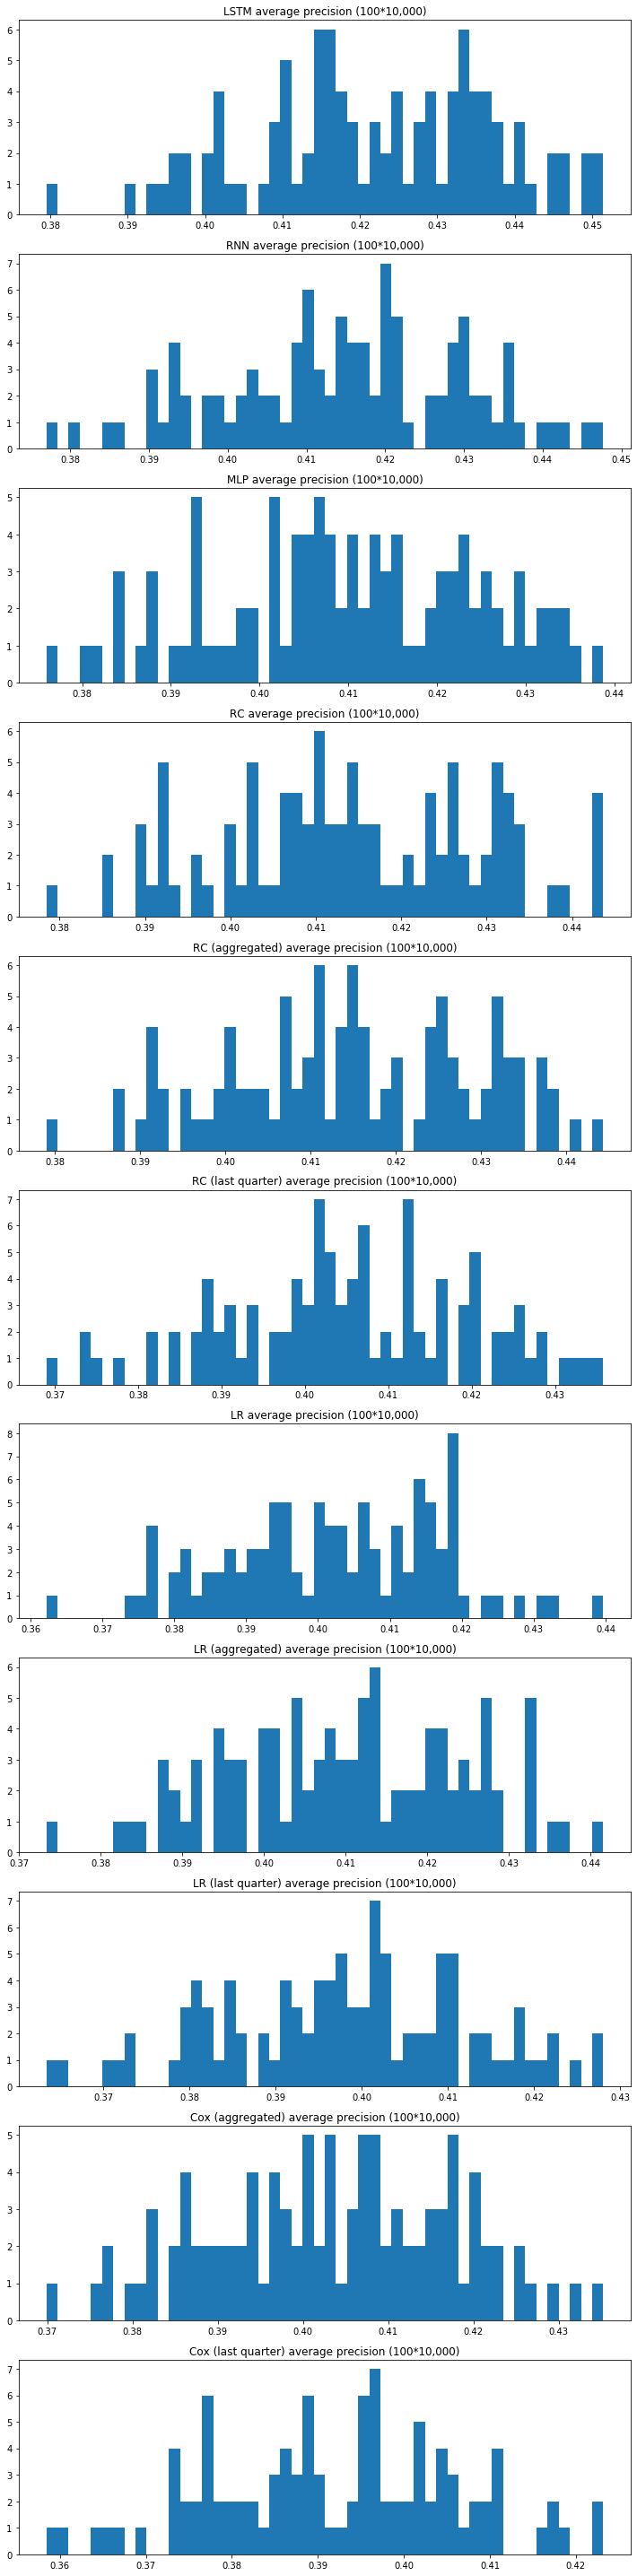

In [31]:
from sklearn.metrics import average_precision_score
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind

n_per_fold = bstrap_v.shape[0]//100
print("Number per fold:", n_per_fold)

ap_scores = np.empty((100, 11))

for i in range(100):
    for j in range(11):
        ap_scores[i, j] = average_precision_score(bstrap_v[(i*n_per_fold):
                                                           ((i+1)*n_per_fold), 0], 
                                                  bstrap_v[(i*n_per_fold):
                                                           ((i+1)*n_per_fold), (j+1)])
print(np.round(ap_scores, decimals=3))
fig, axs = pyplot.subplots(11, 1, figsize=(10, 40))
model_names = {0:"LSTM", 1:"RNN", 2:"MLP", 3:"RC", 
               4:"RC (aggregated)", 5:"RC (last quarter)",
               6:"LR", 7:"LR (aggregated)", 
               8:"LR (last quarter)", 9:"Cox (aggregated)",
               10:"Cox (last quarter)"}
for i in range(11):
    axs[i].hist(ap_scores[:, i], bins=50)
    axs[i].set_title(model_names[i] + " average precision (100*10,000)")
fig.tight_layout()
pyplot.show()

In [ ]:
ap_scores_df = pd.DataFrame(ap_scores)
ap_scores_df.columns = ["LSTM", "RNN", "MLP", "RC", 
                        "RC (aggregated)", "RC (last quarter)", 
                        "LR", "LR (aggregated)", "LR (last quarter)", 
                        "Cox (aggregated)", "Cox (last quarter)"]
feather.write_dataframe(ap_scores_df, "/home/whsu014/data/ap_scores.feathers")